# Bernstein-Vazirani Algorithm

<hr>

**Problem:**

We are given a function: $$ f : {\{0, 1\}}^n \rightarrow \{0, 1\} $$ as a black box. We only know that: $$ f(x) = s \cdot x $$ for sone hidden binary string *s*, where: $$ s \cdot x $$ is the bitwise product mod 2.

Classically we can find out the *s* string in *n* queries. Question is, can we do better with a qauntum computer? Answer is yes, implementing the Bernstein-Vazirani algorithm which is done in these two steps:

1. Set up the superposition: $$ \frac{1}{2^{n/2}} \sum_{x} (-1)^{f(x)} |x> \tag{1}$$ 
2. Apply Fourier sampling to get *s* 

<hr>

### 1. Set up the initial superposition

First of all we need to set up the useful superposition given by (1). We do it starting with *n* qubits in state |0> and one qubit in state |->: in this example we will use *n = 3* and *s=101*.

In [1]:
n = 3
s = '101'

In [16]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, IBMQ, Aer, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
import matplotlib as mpl
from qiskit.tools.monitor import job_monitor

In [3]:
qr = QuantumRegister(n+1)
cr = ClassicalRegister(n)

circuit = QuantumCircuit(qr, cr)

Set the *n*-th qubit to |-> using H and Z gates (or equivalently X and H):

In [4]:
circuit.h(qr[n])
circuit.z(qr[n])

Apply *H* gate to each other qubit:

In [5]:
for i in range(n):
    circuit.h(qr[i])
    
circuit.barrier()

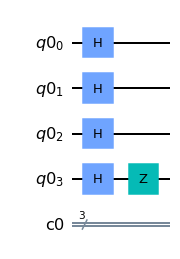

In [6]:
circuit.draw(output='mpl')

We can now compute *f(x)* applying the *s* string to the *n* qubits, than we will have the superposition (1). To do this we just need to toggle the |-> qubit with the *CNOT* gate, in fact |-> pics up a phase of -1 only when the corresponding bit in *s* is 1, giving:

$ \frac{1}{2^{n/2}} \sum_{x} |x> |-> \space \longrightarrow \space \frac{1}{2^{n/2}} \sum_{x} (-1)^{s\cdot x} |x> |->  \tag{2}$

In [7]:
s = s[::-1] # s in reverse order with respect to qiskit notation
for i in range(n):
    if s[i] != '0':
        circuit.cx(qr[i], n)  
        
circuit.barrier()

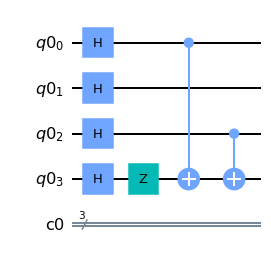

In [8]:
circuit.draw(output='mpl')

### 2. Fourier sampling

Now applying the *H* gate and measure the first *n* qubits we can retrive *s*, in fact using eq. (2) we get:

$$ \frac{1}{2^{n/2}} \sum_{x} (-1)^{s\cdot x} |x> \space \longrightarrow \space \frac{1}{2^{n}} \sum_{x,y} (-1)^{f(x) + x\cdot y} |y>        \tag{3}$$

where the only non-null amplitude is exactly the state |s>, given that the amplitudes are:

$ \frac{1}{2^{n}} \sum_{x} (-1)^{x\cdot s + x\cdot y} = \frac{1}{2^{n}} \sum_{x} (-1)^{x\cdot (s \oplus y)}     \tag{4}$

where the last eqation equals 1 if *s = y* and 0 otherwise.

In [9]:
for i in range(n):
    circuit.h(qr[i])

for i in range(n):
    circuit.measure(qr[i], cr[i])

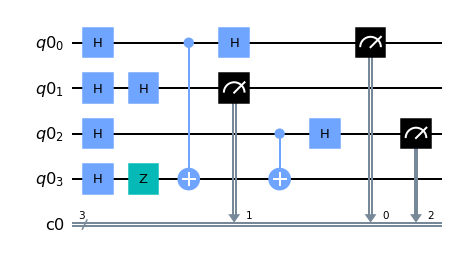

In [10]:
circuit.draw(output='mpl')

## Simulations

First we will run the circuit on the local Aer simulator:

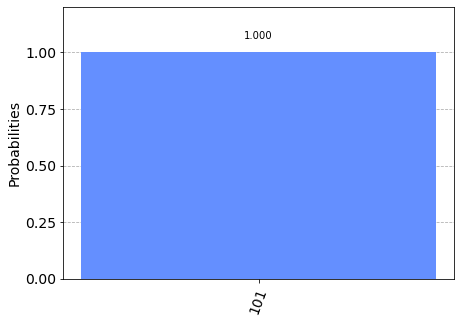

In [11]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

We can then run it on a real quantum computer:

In [12]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_manila


In [13]:
transpiled_circuit = transpile(circuit, backend)
job = backend.run(transpiled_circuit, shots=1024)

job_monitor(job, interval=2)

Job Status: job has successfully run


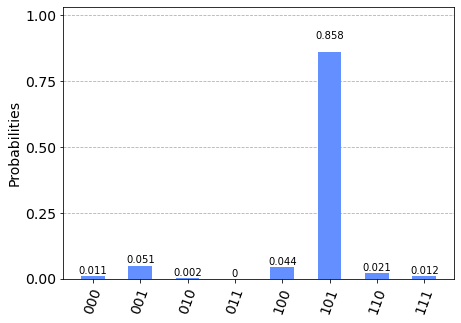

In [14]:
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Note that the circuit would give the same reults even without barriers.